In [1]:
import numpy as np
import random as rd
import tensorflow as tf

from keras.layers import Dense, Embedding, Flatten, Input, concatenate
from keras.models import Model
from keras.optimizers import Adagrad

#Import another jupyter notebook
import import_ipynb
from Productive_CrossValidation_inclTest import *
from Productive_Data_GetTrainTest import samEval


from matplotlib import pyplot

from sklearn.model_selection import StratifiedKFold

import keras_metrics as km 

from keras.utils import to_categorical
from keras.models import clone_model
from keras.callbacks import ReduceLROnPlateau

import import_ipynb
from Productive_TimeHistory import TimeHistory

from keras.models import load_model

C:\Users\twitter\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from Productive_CrossValidation_inclTest.ipynb
importing Jupyter notebook from Productive_TimeHistory.ipynb
importing Jupyter notebook from Productive_Data_GetTrainTest.ipynb


In [2]:
#for reproducability of the results
seed = 7
np.random.seed(seed)
tf.set_random_seed(seed)
rd.seed(seed)

In [3]:
path = 'data/'
outputpath ='outputs/05_callbacks_samEval2018/'

In [4]:
#Load necessary data
train_data, train_labels, test_data, test_labels, word_index, MAX_SEQUENCE_LENGTH = samEval()

In [5]:
#Load pretrained embeddings
import gensim
from gensim.models import KeyedVectors

#Pretrained Google News Embeddings, Dimension 300
GOOGLEEMB = path + 'GoogleNews-vectors-negative300.bin'

embedding= KeyedVectors.load_word2vec_format(GOOGLEEMB, binary=True)

word_vectors = embedding.wv

C:\Users\twitter\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\twitter\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [6]:
#Create embedding-matrix, serves the Keras Embedding Layer as weigths
EMBEDDING_DIM=300

embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector   
    except:
        # words not found in embeddings will be zero
        pass

In [7]:
#Load POS data
def get_pos(file):
    pos =[]
    with open(file, 'r') as f:
        for line in f:
            pos.append([int(i) for i in line.split(',')])
    pos= np.asarray(pos)
    return pos

train_pos =get_pos('output_trainTestData/SamEval_train_pos.csv')
test_pos = get_pos('output_trainTestData/SamEval_test_pos.csv')

In [8]:
#Load Sentiment data
def get_sentiment(file):
    senti =[]
    with open(file, 'r') as f:
        for line in f:
            senti.append([float(i) for i in line.split(',')])
    senti= np.asarray(senti)
    return senti

train_senti_blob =get_sentiment('output_trainTestData/SamEval_train_data_sentiment_blob.csv')
test_senti_blob = get_sentiment('output_trainTestData/SamEval_test_data_sentiment_blob.csv')
train_senti_vadar =get_sentiment('output_trainTestData/SamEval_train_data_sentiment_vadar.csv')
test_senti_vadar = get_sentiment('output_trainTestData/SamEval_test_data_sentiment_vadar.csv')

### Hyperparameter for all models

In [9]:
BATCH_SIZE = 64
NUM_EPOCHS = 30
softmax = True
lossfunction ='binary_crossentropy'
optimizer = Adagrad(lr=0.001)

Instructions for updating:
Colocations handled automatically by placer.


## The model

In [10]:
#First part
wv_layer_1 = Embedding(len(word_index)+1,
                 EMBEDDING_DIM,
                 weights=[embedding_matrix],
                 input_length=MAX_SEQUENCE_LENGTH,
                 trainable=True)

comment_input_1 = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')
embedded_sequences_1 = wv_layer_1(comment_input_1)
x_first_1 = Dense(600, activation='relu')(embedded_sequences_1)
x_first_1 = Flatten()(x_first_1)

#Second part
senti_input_1_blob = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_second_1 = Dense(600, activation='relu')(senti_input_1_blob)

#Thrid part
senti_input_1_pos = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float')
x_third_1 = Dense(600, activation='relu')(senti_input_1_pos)

#Concatination
concat_1 = concatenate([x_first_1, x_second_1, x_third_1])

preds_1 = Dense(2, activation='softmax')(concat_1)

model_1 = Model(inputs=[comment_input_1, senti_input_1_blob, senti_input_1_pos], outputs=preds_1)
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 300)      4118700     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 40, 600)      180600      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_3 (I

# Terminate on NaN

In [11]:
from keras.callbacks import TerminateOnNaN
#model = Kearas model
#softmax = boolean, true if the model uses softmaxe in the output layer otherwise false
#outputpath = path were the output csv should be stored
#outputname = name to use for the output csv
def train_evaluate_three_inputs_terminate(model, nrepochs, nrbatch, optimizer, lossfunction, train_data, train_data2, train_data3,
                                train_labels, test_data, test_data2, test_data3, test_labels, softmax, outputpath, outputname):
    import datetime
    
    seed = 7
    np.random.seed(seed)
    tf.set_random_seed(seed)
    rd.seed(seed)
    
    #needed for softmax-activation
    if softmax:
        labelstrain = to_categorical(train_labels)
        labelstest = to_categorical(test_labels)
    else:
        labelstrain = train_labels
        labelstest = test_labels

    time_callback = TimeHistory() 
    terminate = TerminateOnNaN()
    
    #evaluate the positive class (=ironic data)
    precision =km.binary_precision(label=1)
    recall = km.binary_recall(label=1)
    f1 = km.f1_score(label=1)

    model.compile(loss = lossfunction,
          optimizer=optimizer,
          metrics=['accuracy', precision, recall, f1])

    #Train the model 
    hist= model.fit([train_data, train_data2, train_data3], labelstrain, epochs=nrepochs, batch_size=nrbatch, 
                    shuffle=True, verbose = 0, callbacks=[time_callback, terminate])

    from matplotlib import pyplot
    %matplotlib inline
    pyplot.figure(figsize=(15,10))
    pyplot.plot(hist.history['acc']) 
    pyplot.plot(hist.history['f1_score'])
    #pyplot.plot(hist.history['loss'])
    pyplot.xticks(np.arange(1,nrepochs))
    pyplot.legend(['Train Accuracy', 'Train F1', 'Validation Accuracy', 'Validation F1', 'Loss'], loc=(1.04,0.5))
    pyplot.show()

    #Store the keras model
    model.save(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+'_'+outputname+
                   '_'+'_model.h5')        
    
    score = model.evaluate([test_data,test_data2, test_data3], labelstest, verbose = 0)
    
    print("\n-----Test Scores----")
    print("Loss: " + str(score[0]))
    print("Accuracy: " + str(score[1]*100))
    print("Precision: " + str(score[2]*100))
    print("Recall: " + str(score[3]*100))
    print("F1: " + str(score[4]*100))


    #stores the test results        
    f= open(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+' '+outputname+'_finaltestresults.csv','w+')
    f.write('Loss;'+str(score[0])+'\n'+
            'Accuracy;'+str(score[1])+'\n'+
            'Precision;'+str(score[2])+'\n'+
            'Recall;'+str(score[3])+'\n'+
            'F1;'+str(score[4])+'\n')
    f.close() 

Instructions for updating:
Use tf.cast instead.


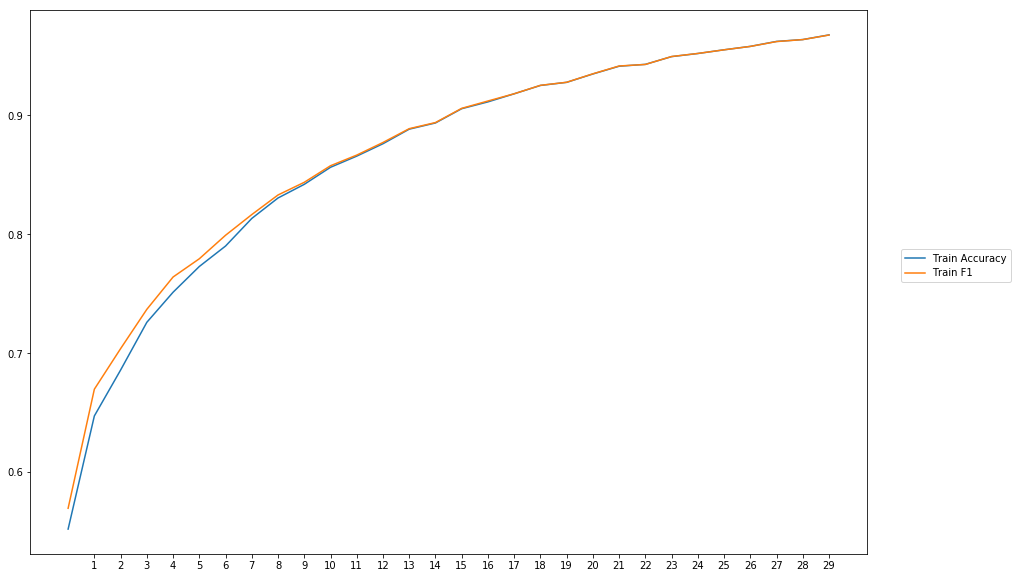


-----Test Scores----
Loss: 0.6049317097177311
Accuracy: 70.1530612244898
Precision: 60.10498686086484
Recall: 73.6334404907931
F1: 66.18496613030041


In [12]:
train_evaluate_three_inputs_terminate(model_1, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'TErminateOnNaN')

# Terminate on NaN and reduce leraning rate

In [11]:
from keras.callbacks import TerminateOnNaN
#model = Kearas model
#softmax = boolean, true if the model uses softmaxe in the output layer otherwise false
#outputpath = path were the output csv should be stored
#outputname = name to use for the output csv
def train_evaluate_three_inputs_terminatereduce(model, nrepochs, nrbatch, optimizer, lossfunction, train_data, train_data2, train_data3,
                                train_labels, test_data, test_data2, test_data3, test_labels, 
                                softmax, outputpath, outputname, lr_monitor, lr_patience, lr_factor):
    import datetime
    
    seed = 7
    np.random.seed(seed)
    tf.set_random_seed(seed)
    rd.seed(seed)
    
    #needed for softmax-activation
    if softmax:
        labelstrain = to_categorical(train_labels)
        labelstest = to_categorical(test_labels)
    else:
        labelstrain = train_labels
        labelstest = test_labels

    time_callback = TimeHistory() 
    terminate = TerminateOnNaN()
    reduce_lr = ReduceLROnPlateau(monitor=lr_monitor, factor=lr_factor,
                              patience=lr_patience, min_lr=0.00001)
    
    #evaluate the positive class (=ironic data)
    precision =km.binary_precision(label=1)
    recall = km.binary_recall(label=1)
    f1 = km.f1_score(label=1)

    model.compile(loss = lossfunction,
          optimizer=optimizer,
          metrics=['accuracy', precision, recall, f1])

    #Train the model 
    hist= model.fit([train_data, train_data2, train_data3], labelstrain,  validation_split=0.2, epochs=nrepochs, batch_size=nrbatch, 
                    shuffle=True, verbose = 0, callbacks=[time_callback, terminate, reduce_lr])

    from matplotlib import pyplot
    %matplotlib inline
    pyplot.figure(figsize=(15,10))
    pyplot.plot(hist.history['acc']) 
    pyplot.plot(hist.history['f1_score'])
    #pyplot.plot(hist.history['loss'])
    pyplot.xticks(np.arange(1,nrepochs))
    pyplot.legend(['Train Accuracy', 'Train F1', 'Validation Accuracy', 'Validation F1', 'Loss'], loc=(1.04,0.5))
    pyplot.show()

    #Store the keras model
    model.save(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+'_'+outputname+
                   '_'+'_model.h5')        
    
    score = model.evaluate([test_data,test_data2, test_data3], labelstest, verbose = 0)
    
    print("\n-----Test Scores----")
    print("Loss: " + str(score[0]))
    print("Accuracy: " + str(score[1]*100))
    print("Precision: " + str(score[2]*100))
    print("Recall: " + str(score[3]*100))
    print("F1: " + str(score[4]*100))


    #stores the test results        
    f= open(outputpath+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+' '+outputname+'_finaltestresults.csv','w+')
    f.write('Loss;'+str(score[0])+'\n'+
            'Accuracy;'+str(score[1])+'\n'+
            'Precision;'+str(score[2])+'\n'+
            'Recall;'+str(score[3])+'\n'+
            'F1;'+str(score[4])+'\n')
    f.close() 

Instructions for updating:
Use tf.cast instead.


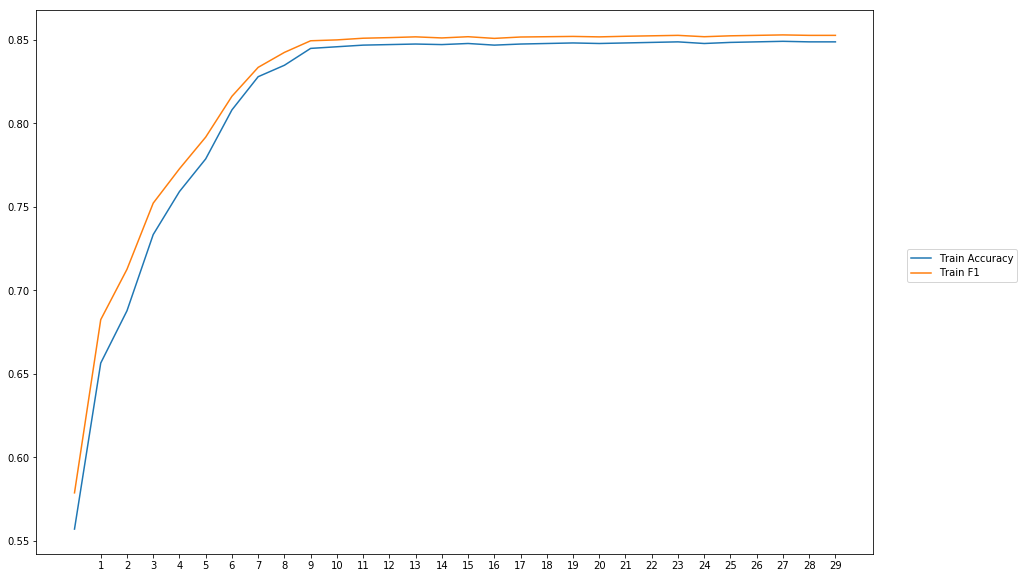


-----Test Scores----
Loss: 0.6496084782542014
Accuracy: 60.96938775510205
Precision: 50.5518763685316
Recall: 73.6334404907931
F1: 59.94763913609178


In [12]:
train_evaluate_three_inputs_terminatereduce(model_1, NUM_EPOCHS, BATCH_SIZE, optimizer, lossfunction, train_data, train_senti_blob, train_pos, train_labels, test_data, test_senti_blob, test_pos, test_labels, softmax, outputpath, 'TerminateOnNaNReduceLR', 'val_acc', 0, 0.1)